In [1]:
import os
import sys
from pathlib import Path

notebook_path = os.path.abspath("".join([p for p in sys.argv if p.endswith(".ipynb")]))
# Find the parent of parent directory of the notebook
top_dir = Path(notebook_path).parents[3]
# top_dir = os.path.dirname(os.path.dirname(os.path.dirname(notebook_path)))
# Add the parent directory to the system path
if top_dir not in sys.path:
    # add the top directory to the beginning of the path
    sys.path.insert(0, top_dir.as_posix())
# print(f"sys.path[0]: {sys.path[0]}")

from typing import Dict, Tuple, Union

import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrow
from torch import Tensor, arange, argwhere, atan2, cat, cos, diff
from torch import empty as empty_tensor
from torch import (float32, gradient, linspace, logical_and, meshgrid, norm,
                   pi, sin, stack, tensor, where, zeros, zeros_like)
from torch.nn import functional as F

from scanner_modeling.beams import (get_beam_sample_line_batch,
                                    get_beams_angle_radian,
                                    get_beams_boundaries_radians,
                                    get_beams_masks, get_beams_weighted_center,
                                    get_beams_width,
                                    sample_ppdf_on_arc_2d_local)
from scanner_modeling.convex_hull import (convex_hull_2d,
                                          sort_points_for_hull_batch_2d)
from scanner_modeling.geometry_2d import (fov_pixels_coordinates,
                                          fov_pixels_to_crystal_rads,
                                          fov_tensor_dict)
from scanner_modeling.io import (load_ppdfs_data_from_hdf5,
                                 load_scanner_geometry_from_layout,
                                 load_scanner_layouts)
# from beam_property_io import (
#     initialize_beam_properties_hdf5,
#     append_to_hdf5_dataset,
#     stack_beams_properties,
# )
from scanner_modeling.plot import (plot_2d_ppdf_mpl,
                                   plot_polygons_from_vertices_mpl,
                                   plot_scanner_from_vertices_2d_mpl)
from scanner_modeling.ppdf import smooth_ppdfs

In [2]:
scanner_layouts_dir = os.path.join(top_dir, "scanner_layouts")
scanner_layouts_filename = "scanner_layouts_e1531c3444e51439add2f18f5714fc50.tensor"
# get the full path to home directory
home_dir = os.path.expanduser("~")
# Define the directory where the PPDFs dataset is stored
ppdfs_dataset_dir = os.path.join(
    home_dir,
    "Work/spebt/data",
)

# Load the scanner layouts
scanner_layouts_data, filename_unique_id = load_scanner_layouts(
    scanner_layouts_dir, scanner_layouts_filename
)

# Define the Field of View (FOV) tensor dictionary
fov_dict = fov_tensor_dict(
    n_pixels=(512, 512),
    size_in_mm=(128, 128),
    center_coordinates=(0.0, 0.0),
    n_subdivisions=(4, 4),
)
# Define the layout index to load
layout_idx = 0

# Load the scanner geometry
(
    plate_objects_vertices,
    crystal_objects_vertices,
    plate_objects_edges,
    crystal_objects_edges,
) = load_scanner_geometry_from_layout(layout_idx, scanner_layouts_data)


# Print the shapes of the loaded data
print(
    f"Layout {layout_idx}:\n"
    + f"Metal plates shape  : {list(plate_objects_vertices.shape)}\n"
    + f"Crystal shapes      : {list(crystal_objects_vertices.shape)}\n"
)

crystal_centers = crystal_objects_vertices.mean(dim=1)
fov_corners = (
    tensor([[-1, -1], [1, -1], [1, 1], [-1, 1]]) * fov_dict["size in mm"] * 0.5
)

hull_points_batch = cat(
    (
        fov_corners.unsqueeze(0).expand(crystal_objects_vertices.shape[0], -1, -1),
        crystal_centers.unsqueeze(1),
    ),
    dim=1,
)
hull_points_batch = sort_points_for_hull_batch_2d(hull_points_batch)
fov_points_xy = fov_pixels_coordinates(fov_dict)
print(f"FOV points shape: {list(fov_points_xy.shape)}")

# define selected crystal index
selected_crystal_idx = 590
print(crystal_centers.shape)

fov_points_rads = fov_pixels_to_crystal_rads(
    fov_points_xy,
    crystal_centers[selected_crystal_idx],
)
print(f"FOV points in radians shape: {list(fov_points_rads.shape)}")
# Set the PPDFs filename for a particular scanner position
ppdfs_hdf5_filename = f"scanner_layouts_e1531c3444e51439add2f18f5714fc50_layout_0.hdf5"

# Load the PPDFs data
ppdfs = load_ppdfs_data_from_hdf5(ppdfs_dataset_dir, ppdfs_hdf5_filename, fov_dict)

treated_ppdf_data_2d = smooth_ppdfs(
    ppdfs.view(-1, int(fov_dict["n pixels"][0]), int(fov_dict["n pixels"][1])),
    threshold=1,
)
print(f"Smoothed PPDFs shape: {list(treated_ppdf_data_2d.shape)}")

Layout 0:
Metal plates shape  : [72, 4, 2]
Crystal shapes      : [864, 4, 2]

FOV points shape: [262144, 2]
torch.Size([864, 2])
FOV points in radians shape: [262144]
Smoothed PPDFs shape: [864, 512, 512]


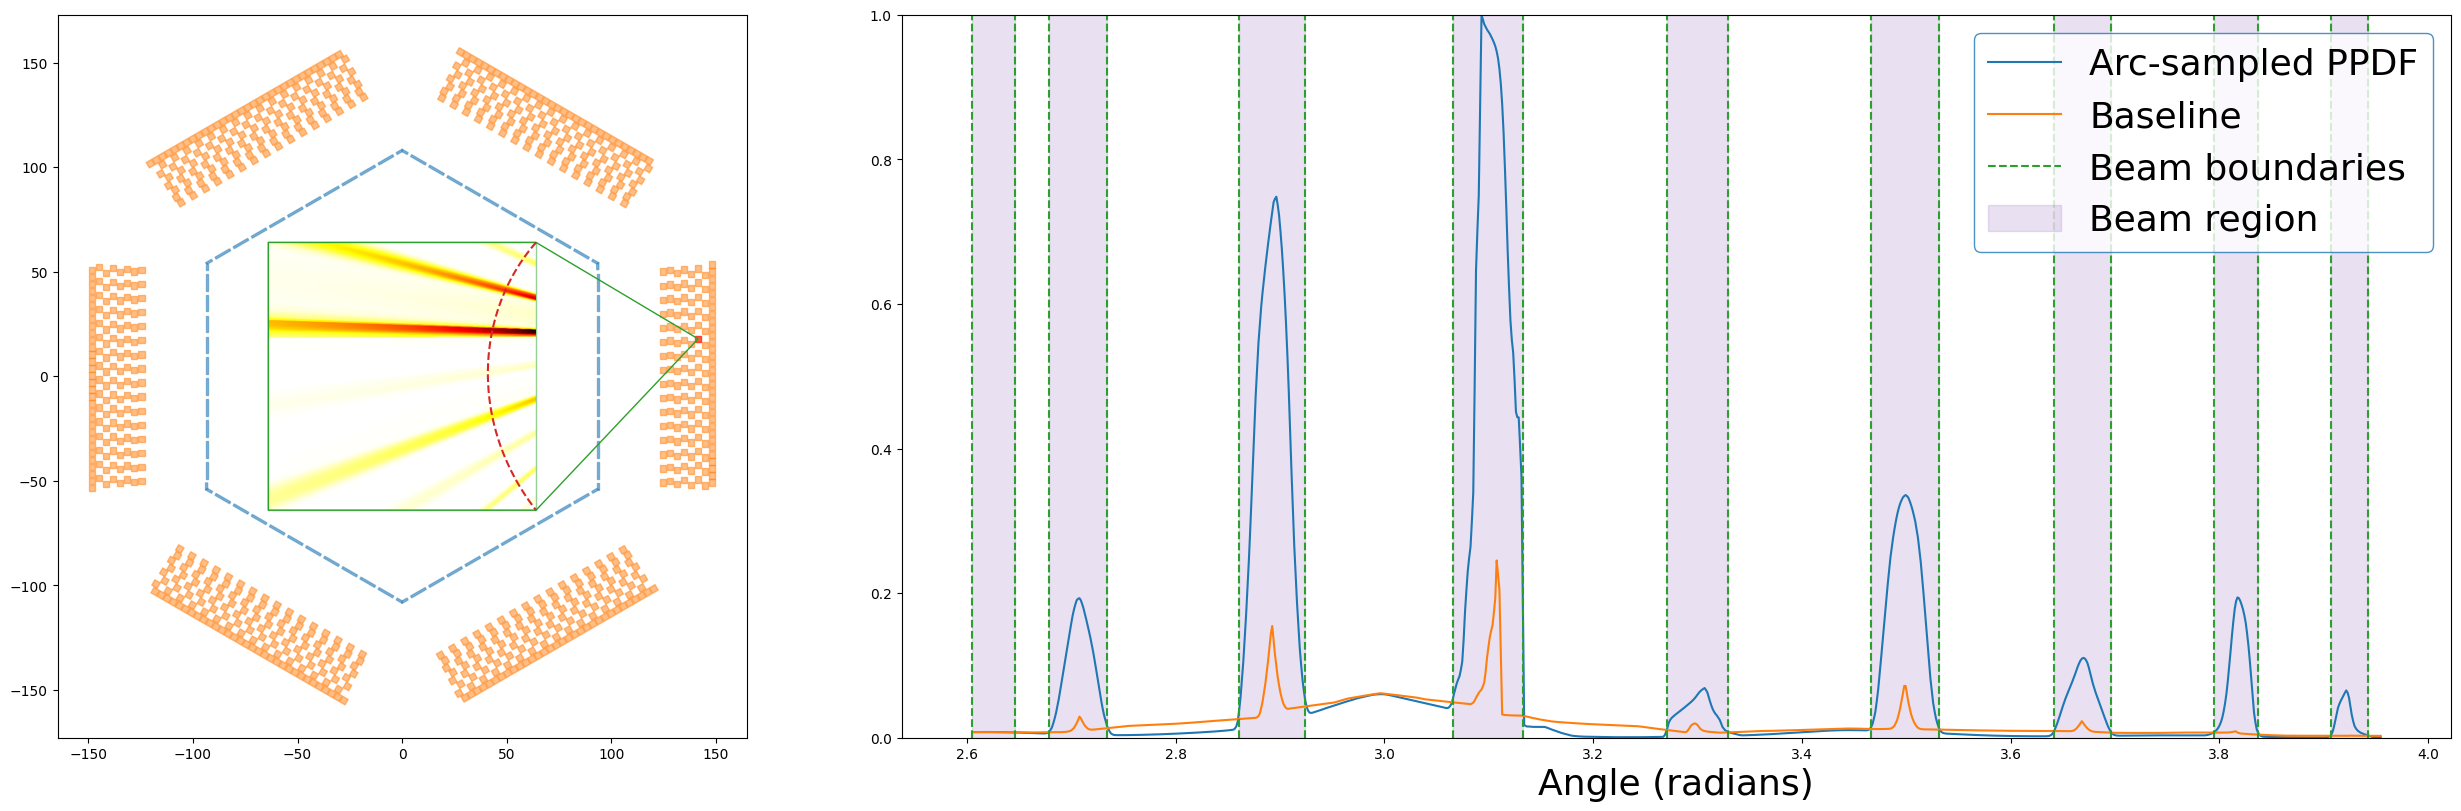

In [3]:
selected_crystal_idx = 90  # 0, 10 , 590,256,120
fov_points_rads = fov_pixels_to_crystal_rads(
    fov_points_xy,
    crystal_centers[selected_crystal_idx],
)

ppdf_data_2d = treated_ppdf_data_2d[selected_crystal_idx]
# Calculate the convex hull for the crystal
hull_2d = convex_hull_2d(hull_points_batch[selected_crystal_idx])

# Sample the PPDFs on the arc of the convex hull
(sampled_ppdf, sampling_rads, sampling_points) = sample_ppdf_on_arc_2d_local(
    ppdf_data_2d, crystal_centers[selected_crystal_idx], hull_2d, fov_dict
)
beams_boundaries, baseline, rectified_sample = get_beams_boundaries_radians(
    sampled_ppdf, sampling_rads
)

plt.close("all")
# Plot the PPDFs and the scanner layout
fig, axs = plt.subplots(
    1,
    2,
    figsize=(25, 8),
    layout="constrained",
    gridspec_kw={"width_ratios": (1, 1.75)},
)

scanner_polycoll = plot_scanner_from_vertices_2d_mpl(
    plate_objects_vertices, crystal_objects_vertices, axs[0], fov_dict
)
selected_crystal_polycoll = plot_polygons_from_vertices_mpl(
    crystal_objects_vertices[selected_crystal_idx].unsqueeze(0),
    axs[0],
    color="red",
    alpha=0.5,
)

hull_mpl_obj = plot_polygons_from_vertices_mpl(
    hull_2d.unsqueeze(0), axs[0], visible=True, fc="none", ec="C2"
)

ppdf_im_obj = plot_2d_ppdf_mpl(
    ppdf_data_2d,
    axs[0],
    fov_dict,
)
ax = axs[0]
ax.autoscale()
ax.set_aspect("equal")
ax.plot(sampling_points[:, 0], sampling_points[:, 1], "--", color="C3", markersize=2)

ax = axs[1]
ax.plot(
    sampling_rads,
    sampled_ppdf / sampled_ppdf.max(),
    color="C0",
    label="Arc-sampled PPDF",
)
ax.plot(sampling_rads, baseline, color="C1", label="Baseline")
boundary_lines = []
beam_regions = []
for boundary_pair in beams_boundaries[:-1]:
    boundary_lines.append(
        ax.axvline(boundary_pair[0], color="C2", linestyle="--", linewidth=1.5)
    )
    boundary_lines.append(
        ax.axvline(boundary_pair[1], color="C2", linestyle="--", linewidth=1.5)
    )
    # fill the area between the boundaries
    beam_regions.append(
        ax.fill_between(
            sampling_rads,
            zeros_like(sampling_rads),
            rectified_sample,
            where=logical_and(
                sampling_rads >= boundary_pair[0],
                sampling_rads <= boundary_pair[1],
            ),
            color="C4",
            alpha=0.2,
        )
    )
boundary_pair= beams_boundaries[-1]
boundary_lines.append(
    ax.axvline(boundary_pair[0], color="C2", linestyle="--", linewidth=1.5)
)
boundary_lines.append(
    ax.axvline(boundary_pair[1], color="C2", linestyle="--", linewidth=1.5,label="Beam boundaries")
)
beam_regions.append(
    ax.fill_between(
        sampling_rads,
        zeros_like(sampling_rads),
        rectified_sample,
        where=logical_and(
            sampling_rads >= boundary_pair[0],
            sampling_rads <= boundary_pair[1],
        ),
        color="C4",
        alpha=0.2,
    label="Beam region"
    )
)
ax.set_ylim(0, 1)
ax.set_xlabel("Angle (radians)", fontsize=26)
ax.legend(
    fontsize=26,
    loc="upper right",
    edgecolor="C0",
)
# fig.savefig(
#     "scanner_layouts_e1531c3444e51439add2f18f5714fc50_layout_0_beams_finding.svg",
#     bbox_inches="tight",
#     dpi=300,
#     transparent=True,
# )

In [4]:
from torch import tan

selected_crystal_idx = 90  # 0, 10 , 590,256,120
fov_points_rads = fov_pixels_to_crystal_rads(
    fov_points_xy,
    crystal_centers[selected_crystal_idx],
)

ppdf_data_2d = treated_ppdf_data_2d[selected_crystal_idx]
# Calculate the convex hull for the crystal
hull_2d = convex_hull_2d(hull_points_batch[selected_crystal_idx])

# Sample the PPDFs on the arc of the convex hull
(sampled_ppdf, sampling_rads, sampling_points) = sample_ppdf_on_arc_2d_local(
    ppdf_data_2d, crystal_centers[selected_crystal_idx], hull_2d, fov_dict
)
beams_boundaries, baseline, rectified_sample = get_beams_boundaries_radians(
    sampled_ppdf, sampling_rads
)


beams_masks = get_beams_masks(
    fov_points_rads,
    beams_boundaries,
)
print(beams_masks.sum(dim=1))
beams_weighted_centers = get_beams_weighted_center(
    beams_masks,
    fov_points_xy,
    ppdf_data_2d,
)
beams_angles = get_beams_angle_radian(
    beams_weighted_centers,
    crystal_centers[selected_crystal_idx],
)
n_beams = beams_weighted_centers.shape[0]


(
    beams_fwhm_batch,
    sample_xy_batch,
    x_bounds_batch,
    sampled_beams_data_batch,
    sample_distance_1d_batch,
) = get_beams_width(
    beams_weighted_centers,
    crystal_centers[selected_crystal_idx],
    beams_masks,
    ppdf_data_2d,
    fov_dict,
    16.0,
)



tensor([  259,  2072, 14747, 19534, 17257, 21237,  8005,  2486,   429])


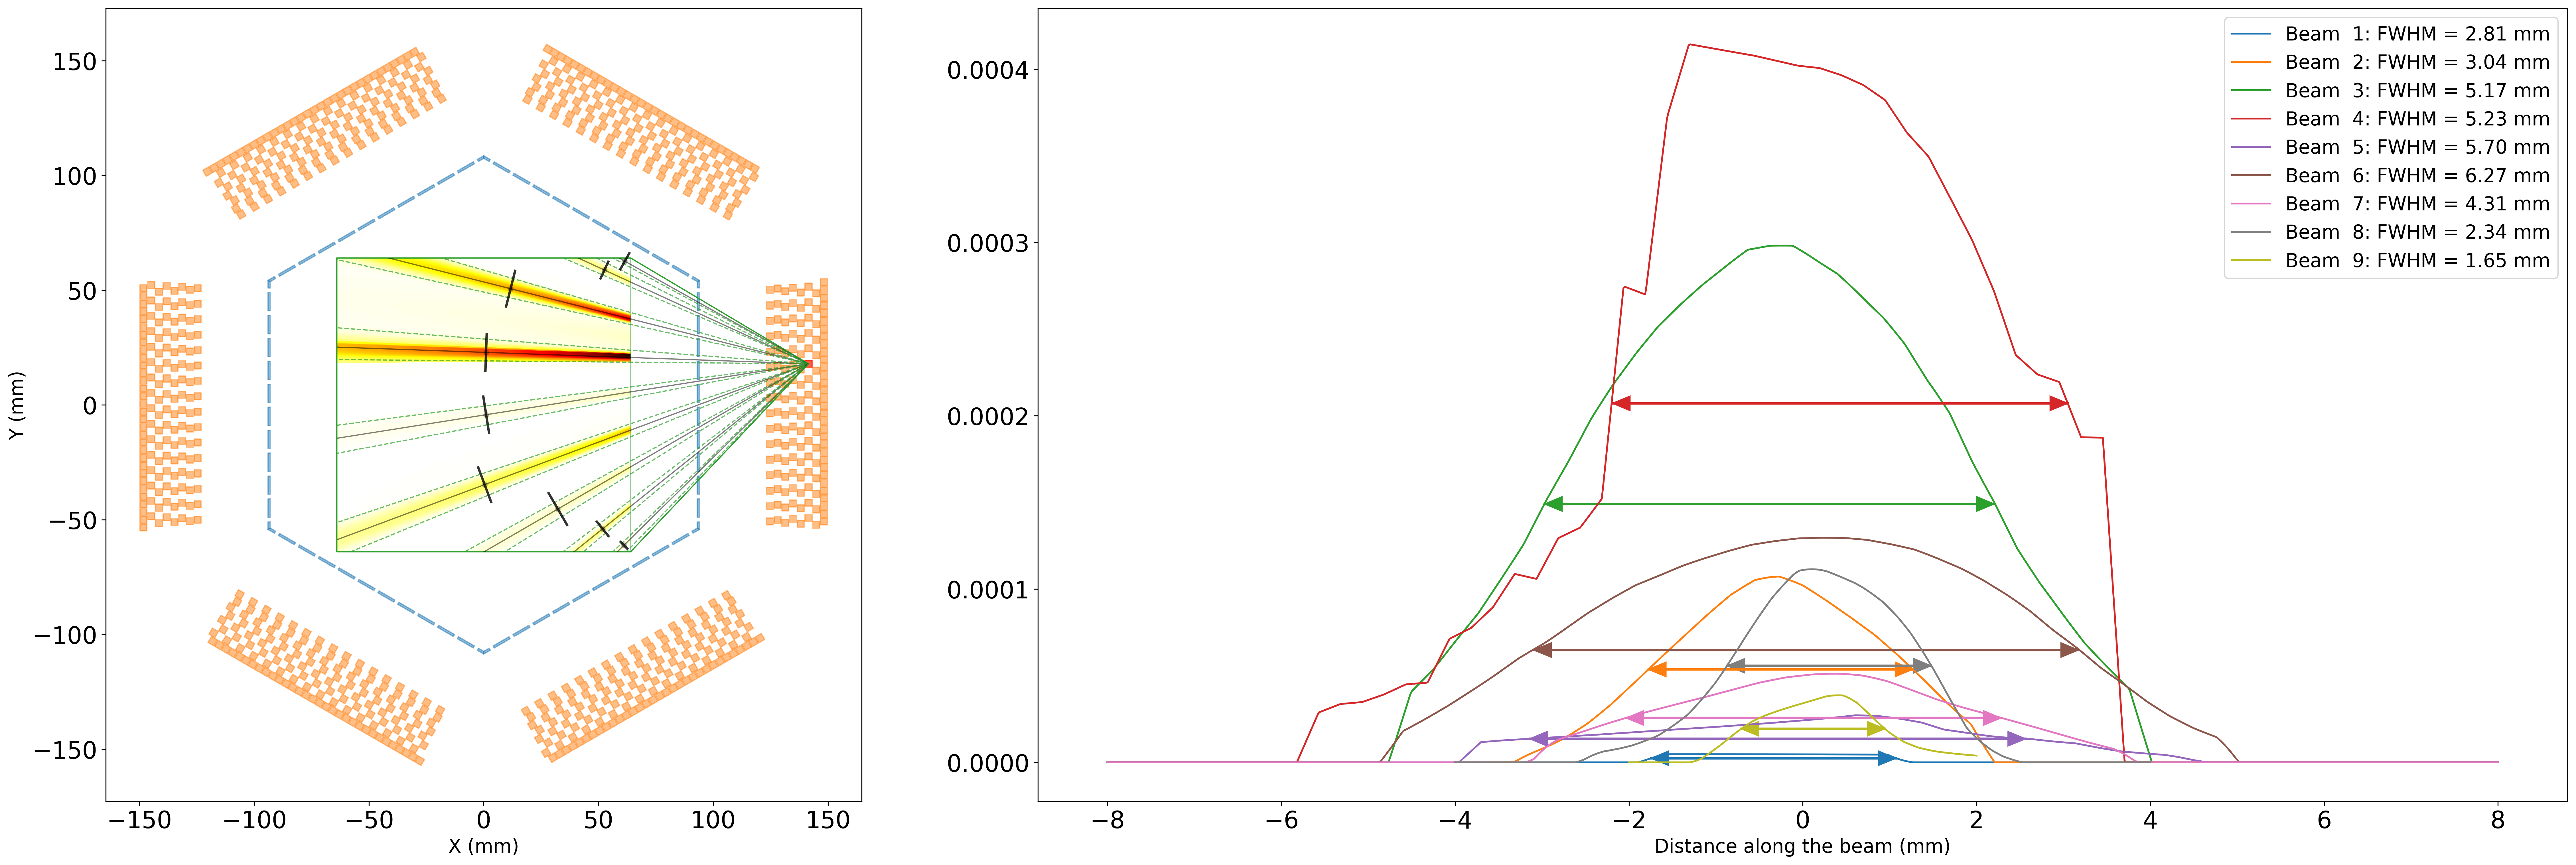

In [5]:
plt.close("all")
plt.rcParams["font.size"] = 20
# Plot the PPDFs and the scanner layout
fig, axs = plt.subplots(
    1,
    2,
    figsize=(30, 10),
    dpi=300,
    layout="constrained",
    gridspec_kw={"width_ratios": (1, 1.75)},
)

scanner_polycoll = plot_scanner_from_vertices_2d_mpl(
    plate_objects_vertices, crystal_objects_vertices, axs[0], fov_dict
)
selected_crystal_polycoll = plot_polygons_from_vertices_mpl(
    crystal_objects_vertices[selected_crystal_idx].unsqueeze(0),
    axs[0],
    color="red",
    alpha=0.5,
)

crystal_centers = crystal_objects_vertices.mean(dim=1)

hull_mpl_obj = plot_polygons_from_vertices_mpl(
    hull_2d.unsqueeze(0), axs[0], visible=True, fc="none", ec="C2"
)

ppdf_im_obj = plot_2d_ppdf_mpl(
    ppdf_data_2d,
    axs[0],
    fov_dict,
)
axs[0].autoscale()
axs[0].set_aspect("equal")


ax = axs[0]
for beam_idx, center in enumerate(beams_weighted_centers):
    ax.plot(
        center[0].item(),
        center[1].item(),
        "o",
        color="k",
        markersize=4,
        alpha=0.2,
        label="Beam center",
    )
    beam_axial_line = ax.axline(
        xy1=(center),
        xy2=(crystal_centers[selected_crystal_idx]),
        color="k",
        linestyle="-",
        linewidth=1,
        alpha=0.5,
    )
    beam_boundary_line_1 = ax.axline(
        xy1=crystal_centers[selected_crystal_idx],
        slope=tan(beams_boundaries[beam_idx][0]).item(),
        color="C2",
        linestyle="--",
        linewidth=1,
        alpha=0.7,
    )
    beam_boundary_line_2 = ax.axline(
        xy1=crystal_centers[selected_crystal_idx],
        slope=tan(beams_boundaries[beam_idx][1]).item(),
        color="C2",
        linestyle="--",
        linewidth=1,
        alpha=0.7,
    )
    beam_axial_line.set_clip_path(
        hull_mpl_obj.get_paths()[0], transform=beam_axial_line.axes.transData
    )
    beam_boundary_line_1.set_clip_path(
        hull_mpl_obj.get_paths()[0], transform=beam_boundary_line_1.axes.transData
    )
    beam_boundary_line_2.set_clip_path(
        hull_mpl_obj.get_paths()[0], transform=beam_boundary_line_2.axes.transData
    )


for sp_points in sample_xy_batch:
    ax.plot(
        sp_points[:, 0],
        sp_points[:, 1],
        color="k",
        lw=2,
        alpha=0.8,
    )
ax.set_xlabel("X (mm)", fontsize=16)
ax.set_ylabel("Y (mm)", fontsize=16)
ax = axs[1]
# ax.set_yscale("log")
sample_data_max = sampled_beams_data_batch.max().item()
arrow_length = 0.2
arrow_width = sample_data_max * 0.005
arrow_head_width = arrow_width * 4
arrow_head_length_ratio = 1.0  # 0.8
arrow_head_length = arrow_length * arrow_head_length_ratio

for i, beam_data in enumerate(sampled_beams_data_batch):
    sample_line_plot = ax.plot(
        sample_distance_1d_batch[i],
        beam_data,
        label=f"Beam {i+1 : 02d}: FWHM = {beams_fwhm_batch[i].item():.2f} mm",
    )
    color = sample_line_plot[0].get_color()
    arrow_y = beam_data.max().item() * 0.5

    arrow_l = FancyArrow(
        x_bounds_batch[i][0].item() + arrow_length,
        arrow_y,
        -arrow_length,
        0,
        width=arrow_width,
        head_length=arrow_head_length,
        head_width=arrow_head_width,
        length_includes_head=True,
        color=color,
        # alpha=0.5,
    )

    arrow_r = FancyArrow(
        x_bounds_batch[i][1].item() - arrow_length,
        arrow_y,
        arrow_length,
        0,
        width=arrow_width,
        head_length=arrow_head_length,
        head_width=arrow_head_width,
        length_includes_head=True,
        color=color,
        # alpha=0.5,
    )
    ax.plot(
        x_bounds_batch[i],
        tensor([arrow_y, arrow_y]),
        color=color,
        # linestyle="--",
        linewidth=2,
        # alpha=0.5,
    )
    ax.add_patch(arrow_l)
    ax.add_patch(arrow_r)
    ax.set_xlabel("Distance along the beam (mm)", fontsize=16)
    ax.legend(loc="upper right", fontsize=16, framealpha=0.8)
# fig.savefig(
#     os.path.join(
#         os.path.dirname(os.getcwd()),
#         f"scanner_layouts_e1531c3444e51439add2f18f5714fc50_layout_{layout_idx}_ppdf_beams_{selected_crystal_idx:03d}.svg",
#     ),
#     dpi=300,
#     transparent=True,
#     bbox_inches="tight",
# )